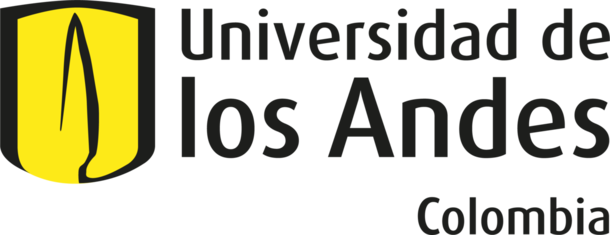

__ISIS3301 - Inteligencia de Negocios__

<div align="center">

## **Laboratorio 2: Regresión**
-------------------------------------

</div>


*   *Julián Castro - 202020847*
*   *Alejandro Gómez - 202015122*
*   *Jonathan Rivera -202022864*


## Objetivos



* Construir modelos analíticos para estimar una variable objetivo continua a partir de un conjunto de variables observadas.


* Comprender el proceso para la construcción de modelos analíticos que responden a una tarea de regresión.


* Automatizar el proceso de construcción de modelos analíticos con el uso de pipelines de tal forma que puedan ser usados en ambientes de producción.


* Extraer información útil para el negocio a partir de los resultados de los modelos de regresión.

## Caso de Negocio: Predicción de muertes per capita de cáncer

La Organización Mundial de la Salud está piloteando un nuevo programa de financiamiento que busca intervenir en poblaciones con un alto número de fallecimientos debido al cáncer. El objetivo es permitirle a los gobiernos nacionales y locales invertir en programas de diagnóstico temprano, instalaciones de tratamiento, entrenamiento de personal hospitalario y financiamiento de la investigación en esta enfermedad. Debido a que este programa busca beneficiar al mediano y largo plazo poblaciones vulnerables, se ha determinado la necesidad de crear un modelo predictivo para empezar interviniendo poblaciones que, dadas sus características, tengan un alto número de muertes por cáncer aunque no haya registros completos u oficiales.

Para ello y de la mano del gobierno norteamericano, la OMS ha recopilado datos de Estados Unidos para la creación del modelo a partir de diversas características demográficas y del estado de los servicios de salud de una población para determinar el número de muertes por cáncer por cada 100.000 habitantes. El objetivo, es que este modelo permita tomar decisiones de la asignación de finaciamiento del nuevo programa, además de determinar qué datos son relevantes y cuáles no lo son para la estimación y la recolección de información.

-----------------------------------------------

La OMS desea que usted los apoye en la construcción del modelo de regresión previamente descrito utilizando algunas de las etapas de la metodología "ASUM-DM":




__1. Entendimiento de los datos:__ Describir la característica más relevantes de los datos, incluir el análisis de calidad de datos y hacer una preselección de las variables más importantes para la etapa de modelado.


__2. Preparación de datos:__ Solucionar cualquier problema de calidad de datos previamente identificado. Además, debe aplicar cualquier proceso de preprocesamiento de datos necesario para la construcción del modelo de regresión.


__3. Modelado:__ Utilizando las variables previamente seleccionadas, construir un modelo de regresión que estime la variable objetivo con el menor error posible.


__4. Evaluación cuantitativa:__ A partir de las métricas seleccionadas para evaluar y seleccionar el mejor modelo, explicar el resultado obtenido desde el punto de vista cuantitativo. Contestar a la pregunta: ¿Su equipo recomienda utlizar en producción el modelo de estimación de precios de portátiles o es preferible continuar haciendo estimaciones de forma manual? En caso de no recomendar el uso del modelo, ¿qué recomendaciones haría para continuar iterando con el objetivo de la construcción de un mejor modelo?


__5. Evaluación cualitativa:__ Debe estar compuesta de dos partes:
- Validación de supuestos: Realizar los ajustes necesarios para que el modelo cumpla con los supuestos necesarios para la inferencia estadística con regresiones.
- Interpretación de los coeficientes: Realizar la interpretación de los coeficientes de la regresión, identificando las variables más relevantes para la estimación y como afectan la variable objetivo.


__6. Visualización de los resultados:__ Integrar el resultado obtenido con el modelo de regresión a un tablero de control para apoyar el objetivo de la empresa.


7. Exportar el mejor modelo (utilizando pipelines) para poder ser usado sobre datos nuevos en el ambiente de producción del cliente.


8. Generar predicciones sobre los datos de prueba que no se encuentran etiquetados utilizando el mejor modelo. Exportar las predicciones en formato CSV utlizando como base el mismo archivo de datos de prueba.

--------------------------------
# **1. Entendimiento de los datos**
--------------------------------

In [3]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats


In [4]:
# Se cargan los datos. 
df =pd.read_csv("./data/202410_Laboratorio 2 - Regresión_train_data.csv", sep=',', encoding = "ISO-8859-1")

In [5]:
# Tamaño del dataset: Filas y columnas
df.shape

(2132, 34)

In [6]:
# Se visualiza una muestra de los registros del dataset
df.sample(5)

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,...,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,deathRate
92,92.0,47,430.4,43476,16436,15.4,0.000000,"(42724.4, 45201]",41.4,39.9,...,38.3,38.1,20.3,79.816959,1.109158,0.400024,0.321232,55.638738,5.987851,213.8
755,22.0,5,358.5,59603,7879,9.9,0.000000,"(54545.6, 61494.5]",40.7,40.5,...,39.3,21.7,12.6,95.909328,0.234497,1.341845,0.677436,40.634441,4.135338,97.9
1960,137.0,60,395.7,46046,37666,20.0,0.000000,"(45201, 48021.6]",32.0,32.5,...,38.7,41.9,28.4,77.044403,2.090518,0.644264,3.980538,52.386167,9.188988,174.0
916,482.0,206,469.6,40270,77510,17.7,12.901561,"(37413.8, 40362.7]",41.6,40.0,...,33.6,44.6,24.0,88.302142,8.280993,1.188641,0.524888,49.670653,3.778506,198.2
1517,3648.0,1186,447.0,100806,765135,7.5,218.262137,"(61494.5, 125635]",39.5,38.2,...,55.7,25.8,13.2,54.976353,2.596260,26.558136,9.447452,53.654254,5.015576,140.0


In [7]:
# Revisar las características de los datos: completitud y tipo de dato
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgAnnCount              2132 non-null   float64
 1   avgDeathsPerYear         2132 non-null   int64  
 2   incidenceRate            2132 non-null   float64
 3   medIncome                2132 non-null   int64  
 4   popEst2015               2132 non-null   int64  
 5   povertyPercent           2132 non-null   float64
 6   studyPerCap              2132 non-null   float64
 7   binnedInc                2132 non-null   object 
 8   MedianAge                2132 non-null   float64
 9   MedianAgeMale            2132 non-null   float64
 10  MedianAgeFemale          2132 non-null   float64
 11  Geography                2132 non-null   object 
 12  AvgHouseholdSize         2132 non-null   float64
 13  PercentMarried           2132 non-null   float64
 14  PctNoHS18_24            

La columna binnedInc representa el ingreso mediano per capita del condado, para que esta información sea util debe ser representada de forma numerica, sin embargo se encuentra representada por el rango del decil en el que se encuentra el condado, por lo tanto si se desea usar, sera neceario tranformar esta informacion, esto se hara en la fase de preparacion de datos

In [8]:
# Resumen de los estadisticos de las variables numéricas
df.describe()

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,MedianAgeFemale,...,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,deathRate
count,2132.000000,2132.000000,2132.000000,2132.000000,2.132000e+03,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,...,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,613.385785,183.537992,448.816467,47029.474203,1.025064e+05,16.889681,158.003002,44.298687,39.559475,42.140009,...,41.237899,36.305113,19.282786,83.686321,9.132512,1.260485,1.953356,51.228950,5.643918,179.000047
std,1435.393846,507.649052,53.582307,12107.930677,3.442282e+05,6.415614,533.636824,39.522898,5.208212,5.272267,...,9.326155,7.847326,6.136426,16.588379,14.613785,2.745672,3.484569,6.565620,1.980214,27.416156
min,6.000000,3.000000,201.300000,22640.000000,8.290000e+02,3.200000,0.000000,23.500000,22.800000,22.800000,...,13.500000,11.200000,2.600000,10.199155,0.000000,0.000000,0.000000,22.992490,0.000000,59.700000
25%,77.000000,28.000000,421.600000,38875.750000,1.154725e+04,12.200000,0.000000,37.700000,36.300000,39.000000,...,34.600000,30.975000,14.900000,77.560360,0.614838,0.263542,0.278374,47.749949,4.520411,161.875000
50%,174.500000,62.000000,453.549422,45207.000000,2.693200e+04,15.900000,0.000000,40.900000,39.600000,42.300000,...,41.300000,36.400000,18.900000,90.122747,2.214754,0.538013,0.781727,51.595091,5.383877,178.550000
75%,515.250000,141.000000,481.600000,52376.250000,6.663525e+04,20.300000,79.275307,44.000000,42.600000,45.400000,...,47.600000,41.425000,23.200000,95.600016,10.709158,1.190457,2.171349,55.398869,6.478029,195.300000
max,38150.000000,14010.000000,1014.200000,125635.000000,1.017029e+07,47.400000,9439.200444,619.200000,64.700000,65.700000,...,70.700000,65.100000,46.600000,100.000000,85.947799,42.619425,37.859023,78.075397,21.326165,293.900000


--------------------------------
### **Análisis de completitud**
--------------------------------

In [9]:
# Cálculo de porcentaje de valores nulos por columna
((df.isnull().sum()/df.shape[0])).sort_values(ascending=False)

PctSomeCol18_24            0.752345
PctPrivateCoverageAlone    0.200750
PctEmployed16_Over         0.053940
PctPublicCoverage          0.000000
PctBachDeg25_Over          0.000000
PctUnemployed16_Over       0.000000
PctPrivateCoverage         0.000000
PctEmpPrivCoverage         0.000000
avgAnnCount                0.000000
PctHS25_Over               0.000000
PctWhite                   0.000000
PctBlack                   0.000000
PctAsian                   0.000000
PctOtherRace               0.000000
PctMarriedHouseholds       0.000000
BirthRate                  0.000000
PctPublicCoverageAlone     0.000000
PctBachDeg18_24            0.000000
avgDeathsPerYear           0.000000
PctHS18_24                 0.000000
PctNoHS18_24               0.000000
PercentMarried             0.000000
AvgHouseholdSize           0.000000
Geography                  0.000000
MedianAgeFemale            0.000000
MedianAgeMale              0.000000
MedianAge                  0.000000
binnedInc                  0

* La columna "PctSomeCol18_24" Tiene casi 3/4 de sus registros con valores nulos, por lo tanto su uso no proporcionaria informacion valiosa, sera necesario removerla en la fase de preparacion de datos
* La columna "PctPrivateCoverageAlone" tiene 20% de los registros en nulo. Es un numero significativo pero no mayoritario, podria considerarse remplazar los valores nulos por el promedio

### Unicidad

In [10]:
df.duplicated(keep = False).sum()

0

### Validez

In [11]:
#Podemos analizar la validez de las variables que recogen la informacion de la demografia racial del condado. La suma de todas las razas
#deberia dar 100% o cercano (posibles errores menores: redondeo,etc)
df["sumPctRace"]=df["PctAsian"]+df["PctBlack"]+df["PctWhite"]+df["PctOtherRace"]
conteo_fuera_de_rango = ((df['sumPctRace'] < 95) | (df['sumPctRace'] > 105)).sum()
porcentaje_fuera_de_rango=conteo_fuera_de_rango/(df["sumPctRace"].count())
porcentaje_fuera_de_rango

0.13367729831144465

13% de las filas se salen del rango de validez deseado para los porcentajes raciales del condado, podriamos analizar descartar estas variables en la fase de preparacion de datos

### Visualisación

In [12]:
#tomamos las variables numericas para visualizarlas
df_numericas = df.select_dtypes(include=['float64', 'int64'])

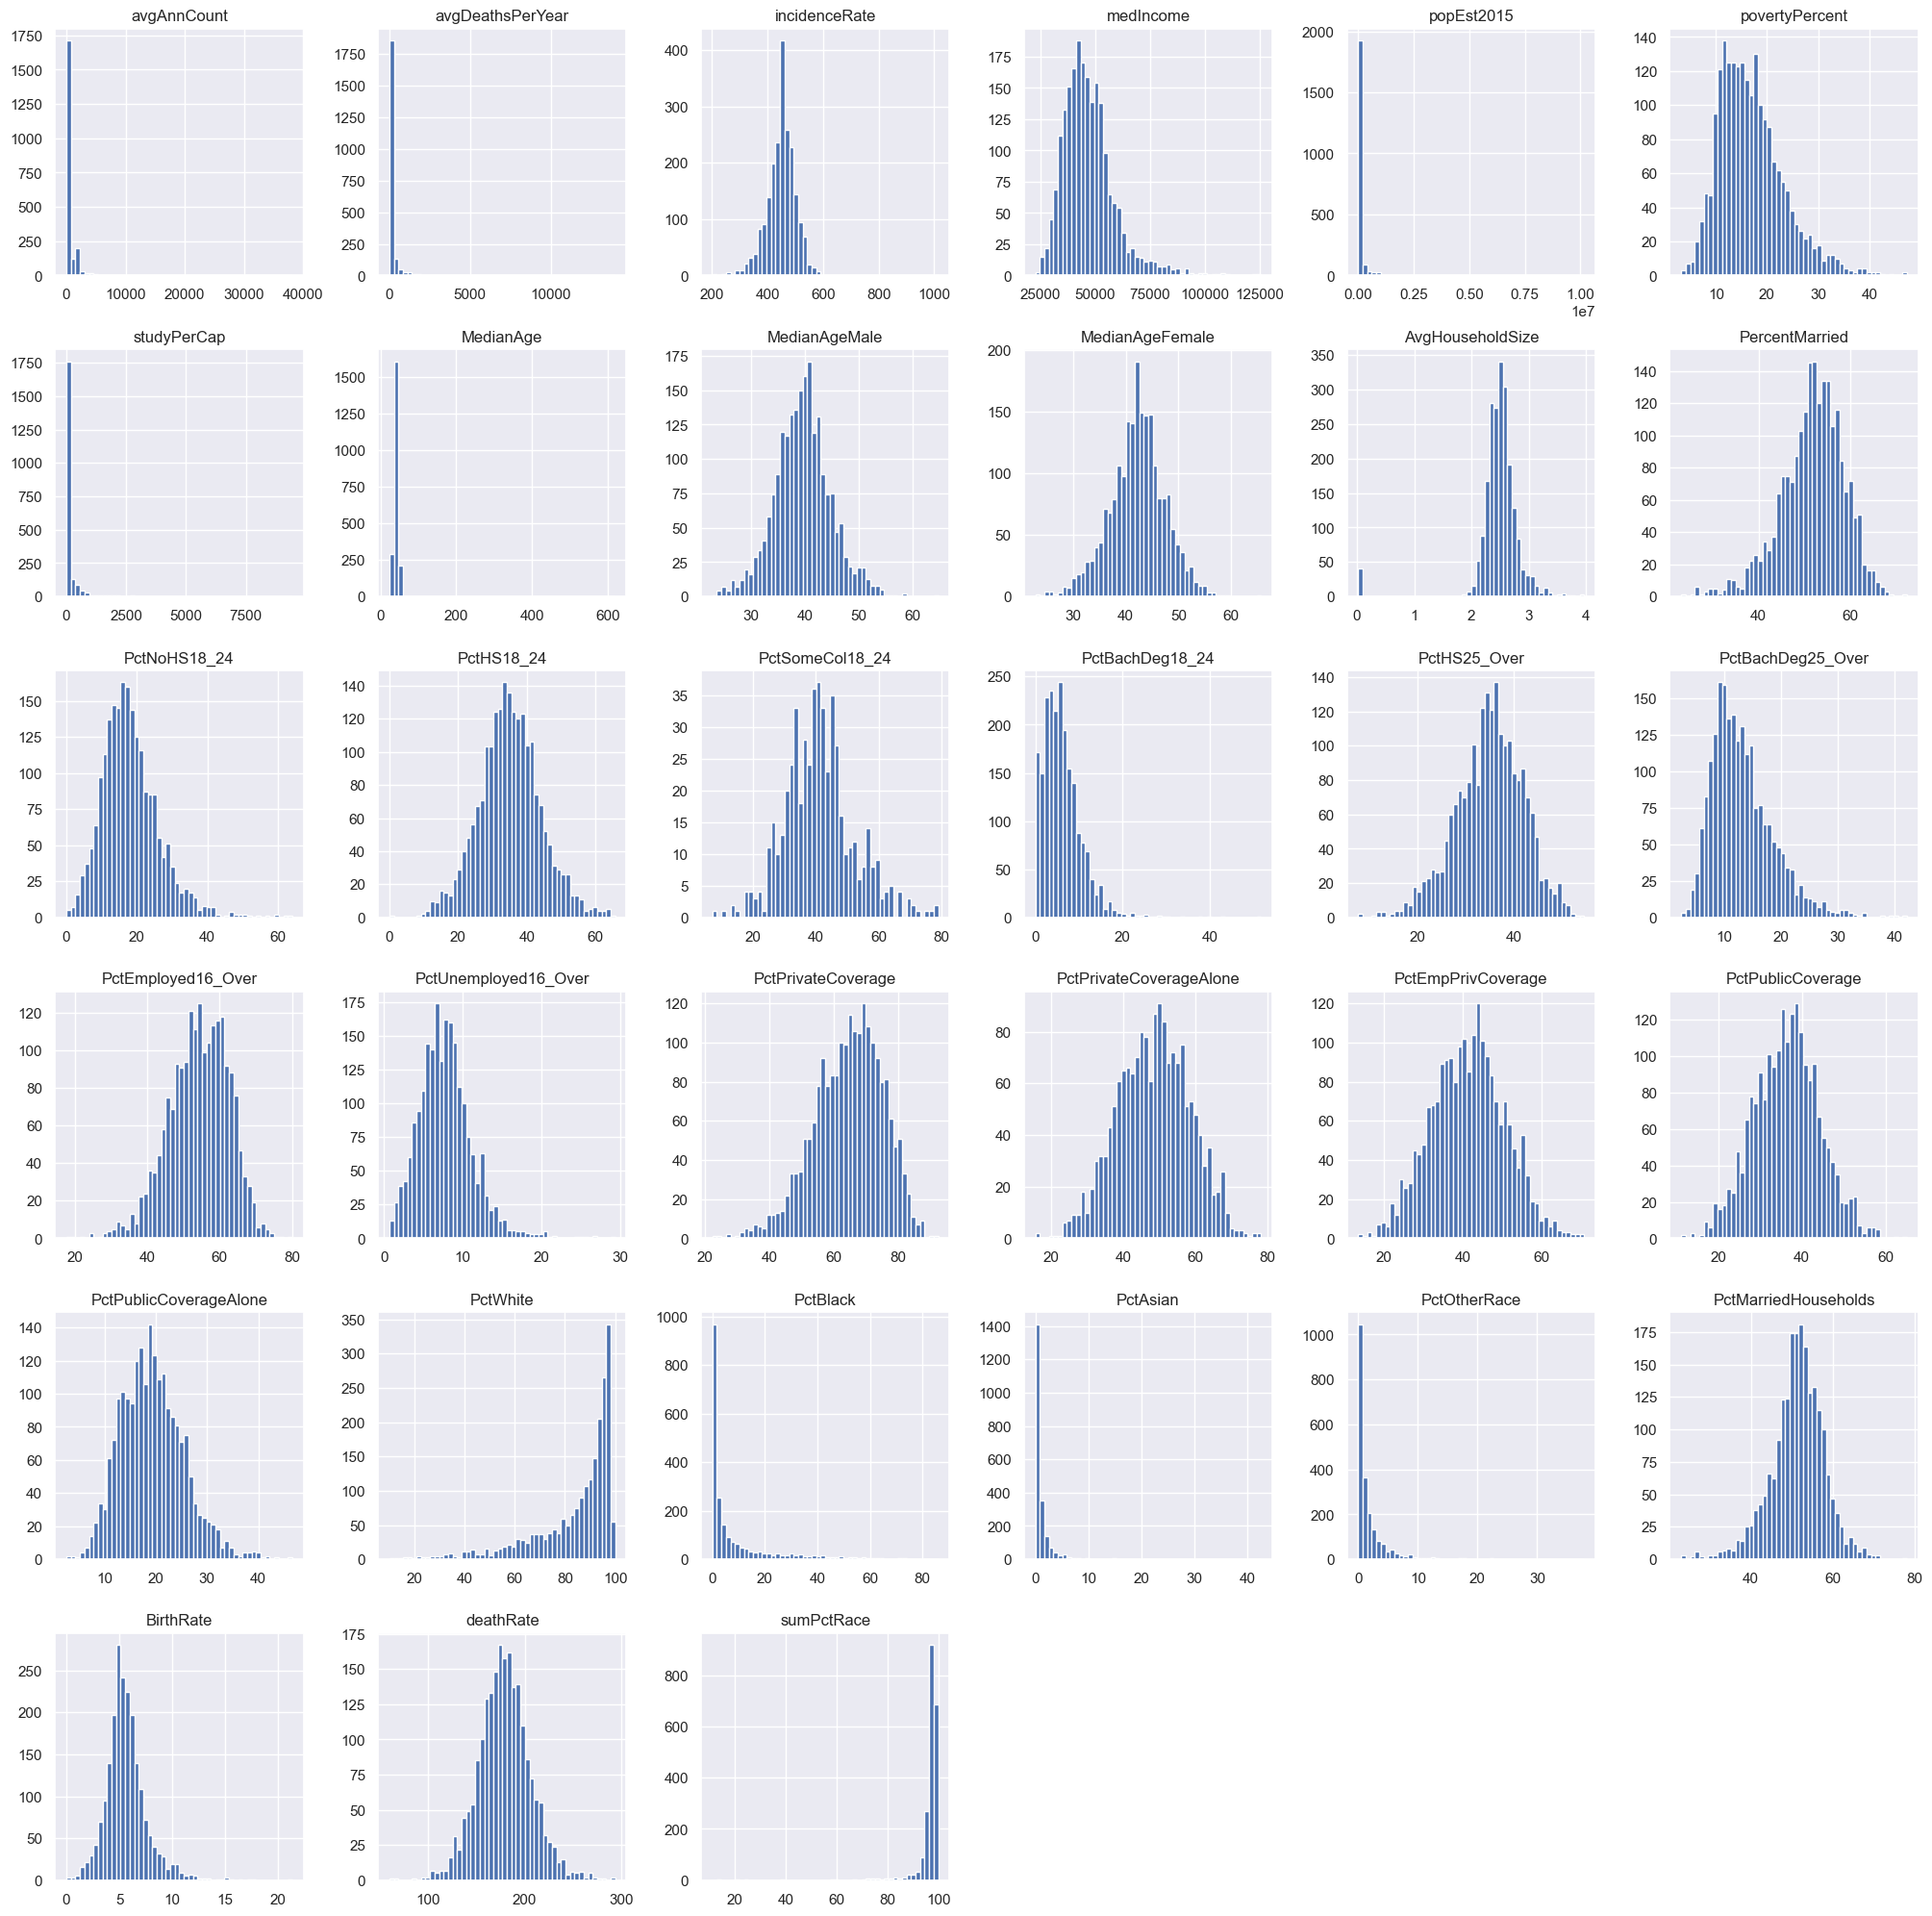

In [13]:
#Creamos un diagrama de distribucion para cada columna numerica
df_numericas.hist(bins=50, figsize=(25, 25))
plt.show()

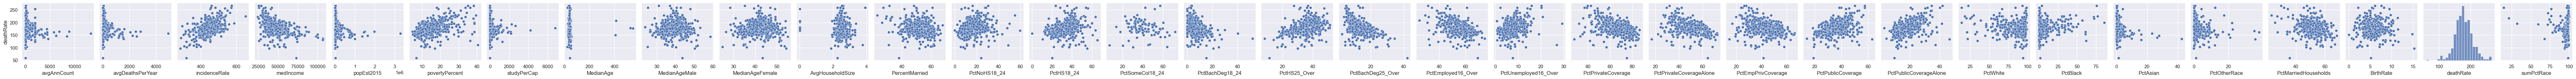

In [14]:
#Procedemos a visualizar la relacion entre las variables y la variable objetivo para validar el modelo posteriormente
sns.pairplot(df_numericas.sample(frac=0.2), y_vars="deathRate", x_vars=df_numericas, kind="scatter")

<Axes: >

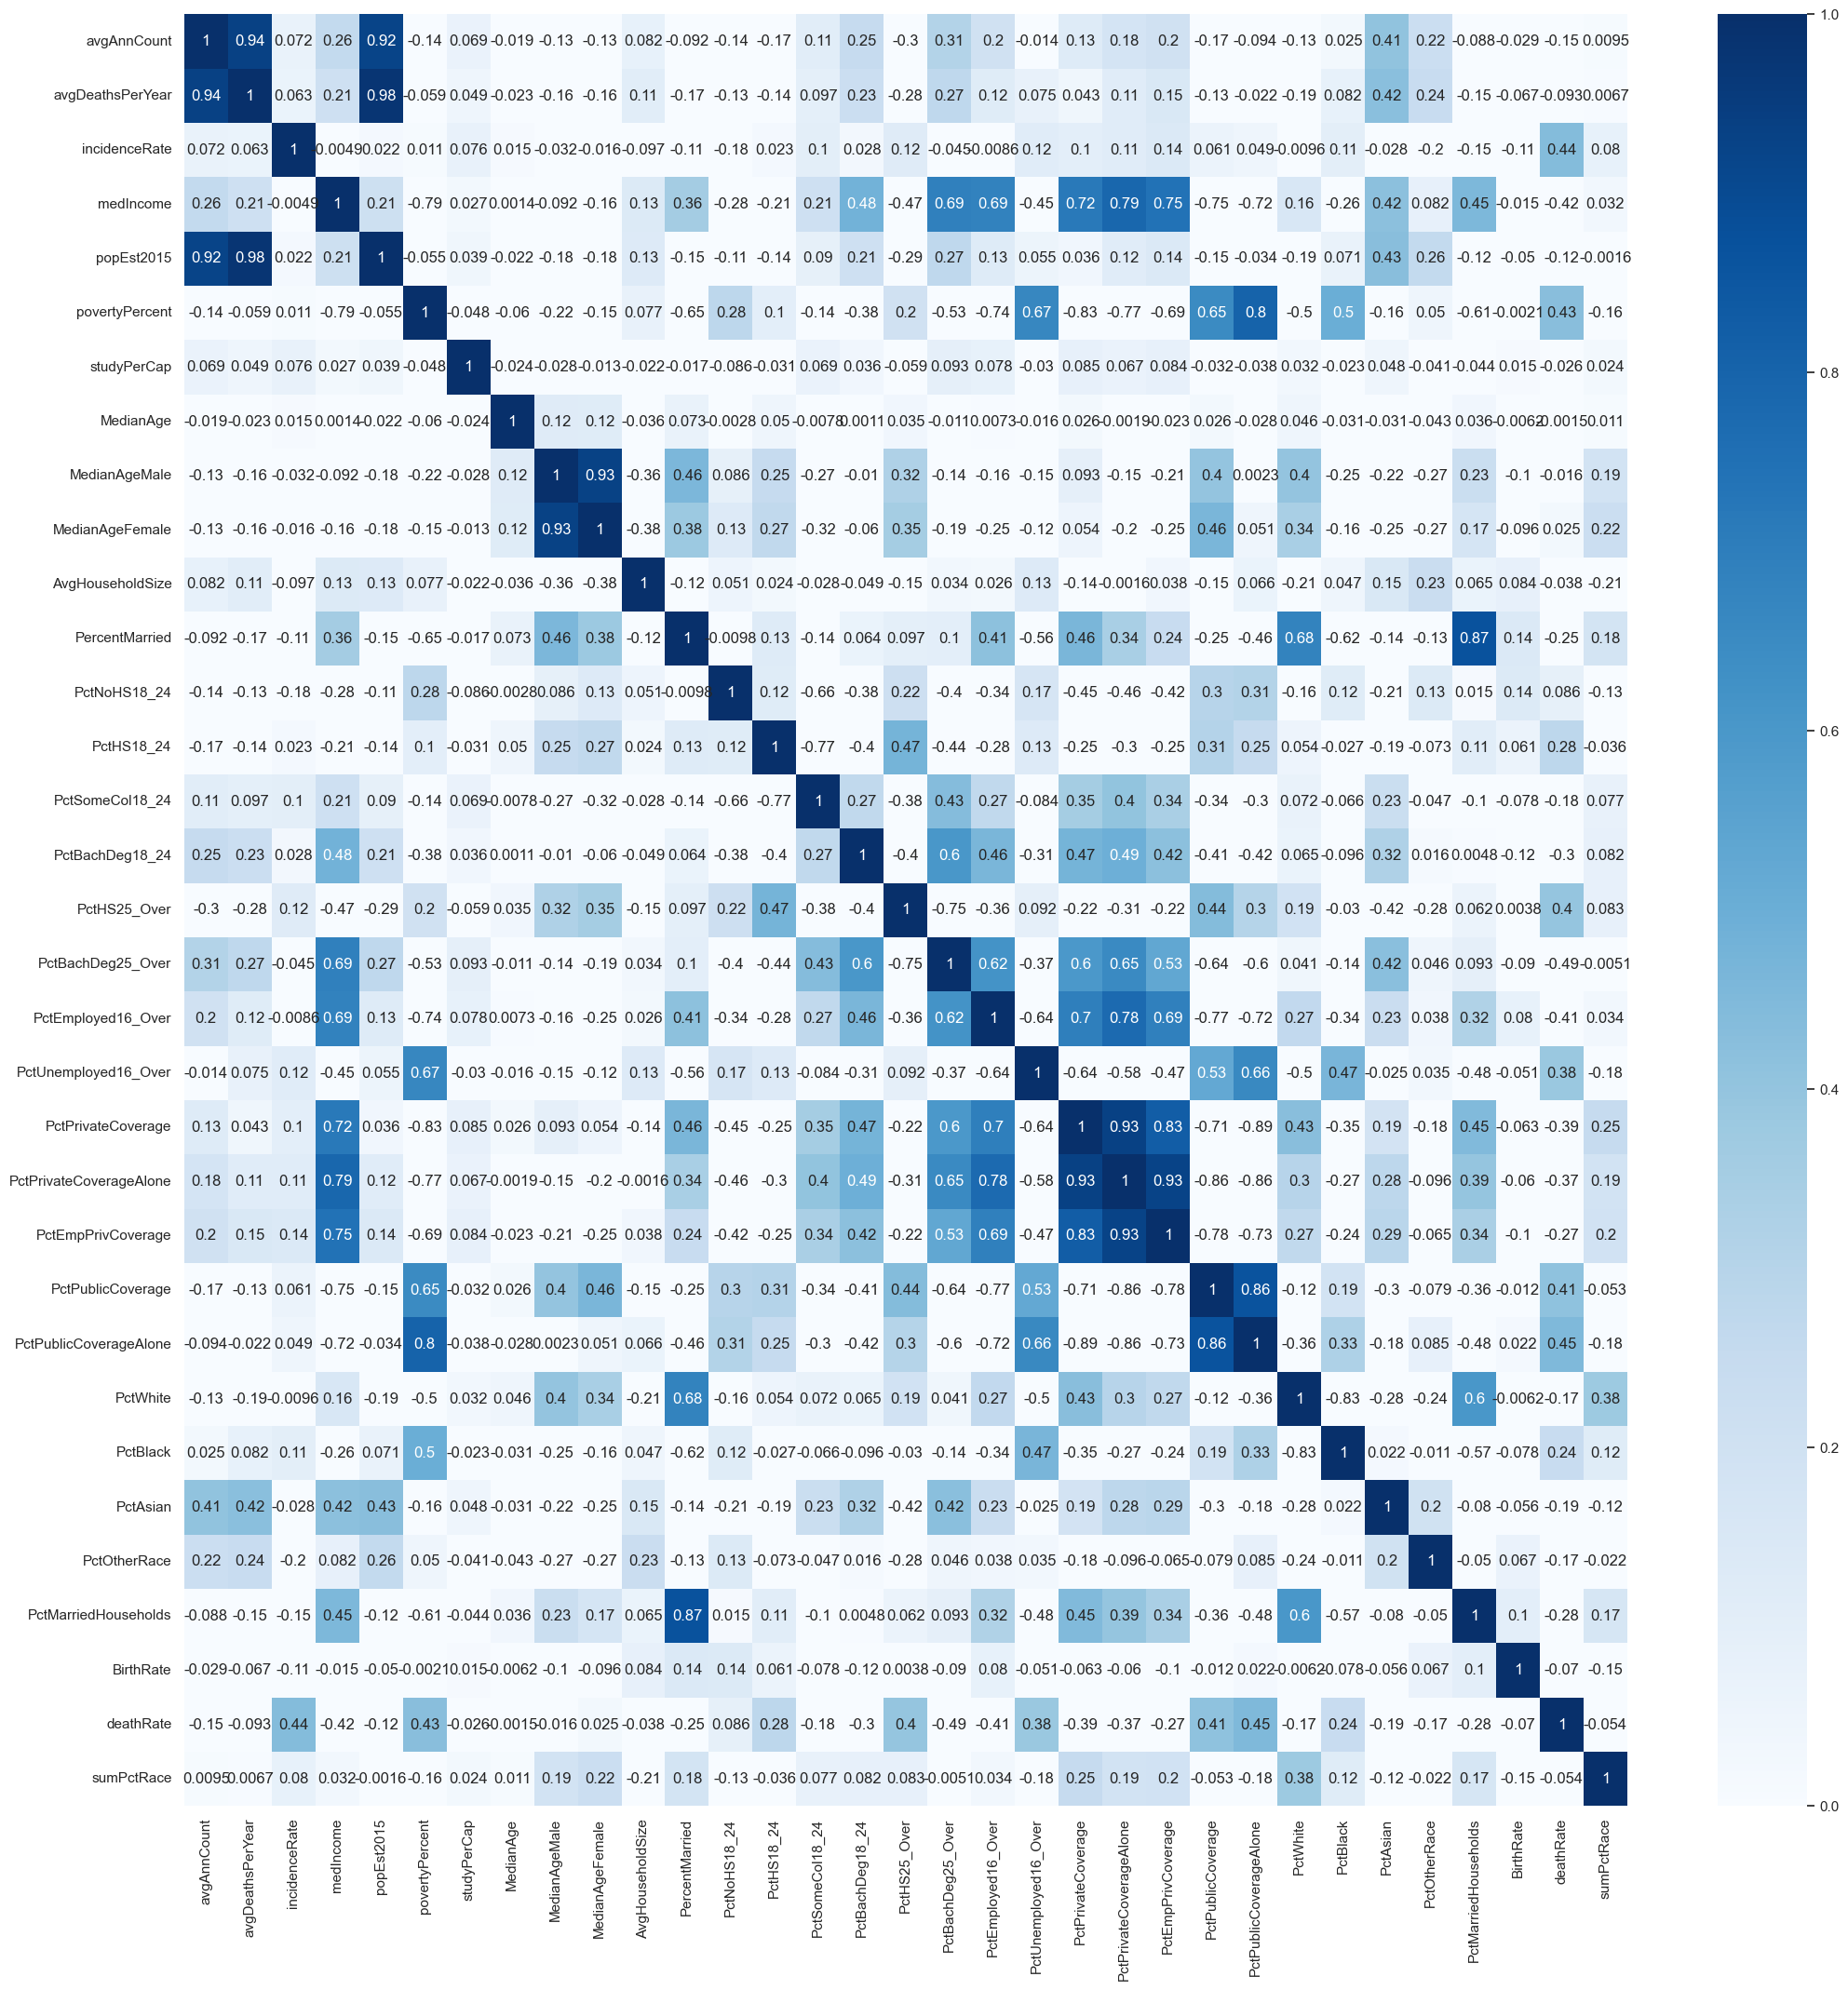

In [15]:
#Podemos mirar las correlaciones entre todas las variables para analizar que variables pueden sacarse
plt.figure(figsize=(25, 25))
sns.heatmap(df_numericas.corr(), cmap="Blues", vmin=0, vmax=1,annot=True)

Podemos ver que para varios conjuntos de variables se presentan altas correlaciones. Podriamos considerar remover variables que se ven representadas en otras variables, debido a su alta correlacion, esto nos permitiria simplificar el modelo sin perder informacion adicional importante.
* La columna popEst2015 (poblacion estimada del condado), esta altamente correlacionada con acgAnnCount(cantidad de casos de cancer dignosticados en promedio cada año) y con avgDeathPerYear (numero promedio de muertes por año). Esto tiene una logica empirica debido a que a mayor poblacion mayor numero de personas con cancer, y una mayor cantidad de muertos cada año, dadas codiciones relativamente iguales. Podriamos decidir quedarnos con solo la columna de acgAnnCount, debido a la que es la que parece mantener una relacion mas directa con el objetivo de negocio. 
* Las variables MedianAgeMale y MedianAgeFemale, tienen una correlacion del 93%, podemos asumir que para la mayoria de condados, la edad media es igual/similar para ambos sexos, por lo tanto podemos elimnar una de estas columnas sin perder información. Podriamos quedarnos con la edad media femenina, debido a que tiene mayor correlacion con la variable objetivo.
* Las columnas PercentMarried y PctMarriedHouseHolds estan altamente correlacionadas tanto de manera matematica como empirica, podemos quedarno con solo una de estas para entrenar al modelo, podriamos quedarnos especificamente con PercentMarried porque describe directamente a los individuos en lugar de grupos de personas, esto tiene una mayor relacion con las otras columnas
* PctPrivateCoverage, PctPrivateCoverageAlone y PctEmpPrivCoverage, se encuentran altaamente correlacionadas entre ellas, podriamos quedarnos con solo una de estas sin perder información valiosa. Debido a que PctPrivateCoverageAlone presenta un gran numero de datos nulos, no sera elegida.Podriamos quedarnos con PctPrivateCoverage sobre PctEmpPrivCoverage, debido a que la primera abarca el fenomeno de la segunda
* PctPublicCoverage y PctPublicCoverageAlone tambien estan altamente correlacionadas. Debido a que PctPublicCoverageAlone tambien se encuentra altamente correlacionada con povertyPercent, podriamos eliminarla sin una repercusion significativa.

--------------------------------
# **2. Preparación de datos**
--------------------------------

### Transformar variable binnedInc a numerica


* Para transformar la variable binnedInc de su formato de objeto, en forma de un rango correspondiente al decil del ingreso medio en el que se encuentra el condado, decidimos rankear los deciles del mas alto al mas bajo, asignarles un valor del 1 al 10, siendo 1 el decil mas bajo y 10 el decil mas alto. 
* Esta transformacion resulta util debido a que ademas de transformar la variable a un valor numerico procesable por el algoritmo de regresion, toma valores en una escala simple. 

In [16]:
df['binnedInc'] = df['binnedInc'].apply(lambda x: float(x.split(',')[0][1:]))
valores_unicos = sorted(df['binnedInc'].unique())
mapeo_rango = {valor: rango+1 for rango, valor in enumerate(valores_unicos)}
df['binnedInc'] = df['binnedInc'].map(mapeo_rango)
df["binnedInc"]

0        2
1        7
2        9
3        1
4        3
        ..
2127     1
2128    10
2129    10
2130     9
2131     9
Name: binnedInc, Length: 2132, dtype: int64

### Seleccion de variables

* Vamos a quitar las columnas/variables que poseen una alta correlacion con otras variables, estas fueron definidas en la fase de entendimiento de datos
* Ademas removeremos la variable Geography, teniendo en cuenta que primero es una variable categorica que no aporta a la regresion lineal, y que ademas solo sirve como identificador de las filas
* La variable PctSomeCol18_24 tiene casi 3/4 de sus filas en nulo, para poder utilizar la columna seria necesario remplazar los valores nulos por la media, sin embargo esto sesgaria de manera considerada la columna hacia el valor medio, dañando su posible utilidad en la regresion, por lo tanto se decidio removerla enteramente

In [52]:
nonecesarias = ["Geography","popEst2015","avgDeathsPerYear","MedianAgeMale","PctMarriedHouseholds","PctPrivateCoverageAlone","PctEmpPrivCoverage","PctPublicCoverage","PctSomeCol18_24"]
df_seleccion1=df.drop(nonecesarias, axis=1)

### Manejo de datos nulos

In [53]:
#De las variables seleccionadas solo PctEmployed16_Over presenta datos nulos. Estos representan un 4% de los registros
#Al tratarse de una cantidad considerablemente baja, vale la pena utilizar la columna, remplazado los valores nulos por el valor medio
#Utilizar el valor medio nos permite mantener la mayoria de la información de la columna relativamente igual

mediana = df_seleccion1["PctEmployed16_Over"].median()  # option 3
df_seleccion1.fillna({"PctEmployed16_Over": mediana}, inplace=True)

In [54]:
#Confirmamos que el dataframe quede sin valores nulos
((df_seleccion1.isnull().sum()/df_seleccion1.shape[0])).sort_values(ascending=False)

avgAnnCount               0.0
PctBachDeg18_24           0.0
deathRate                 0.0
BirthRate                 0.0
PctBlack                  0.0
PctPublicCoverageAlone    0.0
PctPrivateCoverage        0.0
PctUnemployed16_Over      0.0
PctEmployed16_Over        0.0
PctBachDeg25_Over         0.0
PctHS25_Over              0.0
PctHS18_24                0.0
incidenceRate             0.0
PctNoHS18_24              0.0
PercentMarried            0.0
AvgHouseholdSize          0.0
MedianAgeFemale           0.0
MedianAge                 0.0
binnedInc                 0.0
studyPerCap               0.0
povertyPercent            0.0
medIncome                 0.0
sumPctRace                0.0
dtype: float64

### Cargar datos de prueba

In [55]:
test =pd.read_csv("./data/202410_Laboratorio 2 - Regresión_val_data.csv", sep=',', encoding = "ISO-8859-1")

### Definir datos de entrenamiento y validación

In [56]:

X_train, X_test, y_train, y_test = train_test_split(df_seleccion1.drop("deathRate", axis=1), df_seleccion1["deathRate"], test_size=0.3, random_state=1)

print(len(X_train))
print(len(X_test))

1492
640


--------------------------------
# **3. Modelado**
--------------------------------

Utilizaremos la implementacion de regresión lineal simple dado que el objetivo de negocio esta enfocado en el análisis del modelo resultante.

In [22]:
X_train[[]]

,avgAnnCount,incidenceRate,medIncome,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeFemale,AvgHouseholdSize,PercentMarried,...,PctUnemployed16_Over,PctPrivateCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,BirthRate,deathRate,sumPctRace
288,384.0,427.6,56797,13.9,0.000000,9,46.3,48.1,2.47,57.0,...,9.0,66.5,16.7,78.990375,12.277736,1.389569,4.478652,5.818293,146.8,97.136332
1855,316.0,420.9,50243,11.9,0.000000,7,40.9,43.3,2.45,53.8,...,5.5,71.9,17.2,95.251778,0.534989,0.671514,0.612776,4.992504,176.8,97.071057
1554,223.0,312.7,57235,10.2,0.000000,9,42.6,43.1,2.56,59.5,...,7.9,73.7,16.5,96.370061,0.486922,0.476778,0.933268,6.143949,155.7,98.267030
1808,142.0,453.7,38387,19.7,0.000000,3,41.8,42.5,2.57,51.5,...,8.0,59.7,23.3,97.414495,1.099349,0.236156,0.052932,5.300939,189.5,98.802932
408,160.0,415.9,46943,18.0,0.000000,6,42.3,42.9,2.54,58.6,...,4.0,63.6,16.5,97.291852,0.501998,0.485485,0.677037,7.467205,168.0,98.956372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,828.0,477.1,54026,12.7,264.914697,8,39.9,41.1,2.69,53.7,...,9.8,69.1,16.1,81.454691,12.349000,2.260914,1.977997,4.754928,181.0,98.042601
905,590.0,461.3,55915,8.7,187.297803,9,38.7,39.3,2.66,55.6,...,5.3,70.0,17.1,90.413149,5.832228,0.954908,0.523574,5.129672,169.0,97.723859
1096,16.0,409.2,51082,17.5,0.000000,8,29.7,28.5,3.56,40.7,...,12.5,36.8,30.2,18.718618,0.341434,1.446074,0.482025,11.801242,216.6,20.988150
235,105.0,440.8,37263,28.3,0.000000,2,39.0,41.6,2.66,40.8,...,11.9,53.7,25.9,54.669917,35.849587,0.150038,6.376594,8.353222,183.2,97.046137


In [57]:
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

Mediremos los errores para el primer modelo establecido

In [58]:
#MAE
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))

Train: 14.36755397668302


In [59]:
#RMSE
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))

Train: 19.743851987923065


In [60]:
r2_score(y_train.values, regression.predict(X_train))


0.4860909159377723

In [61]:
r2_score(y_test.values, regression.predict(X_test))

0.5008676913266177

## Construccion nuevo modelo manejando los outliers de las variables y normalizando

--------------------------------
# **4. Evaluación Cuantitativa**
--------------------------------

--------------------------------
# **1. Evaluación Cualitativa**
--------------------------------